<a href="https://colab.research.google.com/github/EvenSol/NeqSim-Colab/blob/master/notebooks/process/GasCompressorTrain.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#@title Simulation of a Gas Compression Train
#@markdown A compressor is a mechanical device that increases the pressure of a gas by reducing its volume.
#@markdown Compressors are similar to pumps: both increase the pressure on a fluid and both can transport the fluid through a pipe. As gases are compressible, the compressor also reduces the volume of a gas. Liquids are relatively incompressible; while some can be compressed, the main action of a pump is to pressurize and transport liquids.
%%capture
!pip install neqsim
import neqsim
from neqsim.thermo.thermoTools import *
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
import math
%matplotlib inline

# Litterature

https://petrowiki.org/Compressors

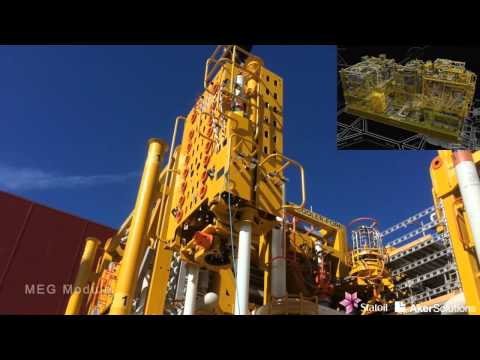

In [2]:
#@title  Åsgard Subsea Gas Compression
#@markdown The installation of the modules that collectively constitute Åsgard subsea gas compression has commenced in the Åsgard field.​
#@markdown Innovative technology at a depth of 300 metres will create more than 300 million extra barrels BOE from the Åsgard field.
from IPython.display import YouTubeVideo
YouTubeVideo('WXaTF_ajADE', width=600, height=400)

# Natural Gas Compressors
 Produced gas pressure at the wellhead normally is not sufficient to allow export for sales and further treatment. Therefore, an export gas compression system is required, with a centrifugal compressor being the most suitable for variable sales gas demand and near-constant export pressure.

Normally, the export gas centrifugal compressor works well under constant inlet pressure. Compressor operation is challenged when the gas well reservoir pressure is reduced (due to reservoir depletion), and when the full well steam (FWS) water cut increases and the gas fraction in the FWS decreases. Consequently, inlet pressure to the compressor is reduced.

The compressor operation becomes unstable due to reduced inlet pressure and reduced flow. To meet the required export gas pressure, the speed of the compressor must be increased. However, the temperature of the compressor discharge also increases at reduced flow and higher speed; therefore, the recycle is also required to maintain the compressor discharge temperature within a defined limit.

In [3]:
#@title  Calculation of a gas compression train
#@markdown This script demonstrates the calculations of a simple gas compression train

from neqsim.thermo import fluid, phaseenvelope
from neqsim.process import separator, heater, clearProcess, stream,  compressor, runProcess, viewProcess, getProcess

gasFlowRate = 5.0#@param {type:"number"} # MSm3/day

temperature_inlet = 35.0 #@param {type:"number"}
pressure_inlet = 55.0 #@param {type:"number"}

pressureMP = 100.0 #@param {type:"number"}
temperatureMP = 35.0 #@param {type:"number"}

pressureExport = 150.0 #@param {type:"number"}
temperatureExport = 35.0 #@param {type:"number"}

fluid1 = fluid('srk')
fluid1.addComponent("nitrogen", 1.0)
fluid1.addComponent("CO2", 2.0)
fluid1.addComponent("methane", 79.2)
fluid1.addComponent("ethane", 7.3)
fluid1.addComponent("propane", 2.3)
fluid1.addComponent("i-butane", 1.0)
fluid1.addComponent("n-butane", 0.7)
fluid1.addComponent("i-pentane", 0.04)
fluid1.addComponent("n-pentane", 0.02)
fluid1.addComponent("n-hexane", 0.003)

fluid1.setPressure(pressure_inlet, 'bara')
fluid1.setTemperature(temperature_inlet, 'C')
fluid1.setTotalFlowRate(gasFlowRate, "MSm3/day")

clearProcess()
stream1 = stream(fluid1)
compressor_1 = compressor(stream1, pressureMP)
compressor_1.setIsentropicEfficiency(0.77)
coolerMP1 = heater(compressor_1.getOutStream())
coolerMP1.setOutTemperature(temperatureMP+273.15)
compressor_2 = compressor(coolerMP1.getOutStream(), pressureExport)
compressor_2.setIsentropicEfficiency(0.77)
coolerExport = heater(compressor_2.getOutStream())
coolerExport.setOutTemperature(temperatureExport+273.15)
runProcess()

print("compressor1 power ", compressor_1.getPower()/1e6, " MW")
print("compressor2 power ", compressor_2.getPower()/1e6, " MW")

print("cooler1 duty ", coolerMP1.getDuty()/1e6, " MW")
print("cooler2 duty ", coolerExport.getDuty()/1e6, " MW")

compressor1 power  4.669057449552735  MW
compressor2 power  2.905806060201757  MW
cooler1 duty  -7.114743580802541  MW
cooler2 duty  -5.1922618404200716  MW


# Fuel gas consumption
This section demonstrates hot to estimate the fule gas consumption.

In [4]:
from neqsim.thermo import fluid, TPflash
from neqsim.standards import ISO6976

referenceTemperatureVolume = 15.0 #@param ['0.0', '15.0', '20.0']
referenceTemperatureCombustion = 25.0 #@param ['0.0', '15.0', '20.0', '25.0']
numberUnit = 'volume' #@param ['volume', 'mass', 'molar']

iso6976 = ISO6976(fluid1)
iso6976.setReferenceType(numberUnit)
iso6976.setVolRefT(float(referenceTemperatureVolume))
iso6976.setEnergyRefT(float(referenceTemperatureCombustion))
iso6976.calculate()


GCV = round(iso6976.getValue("SuperiorCalorificValue")/1.0e3,3)
GCVinf = round(iso6976.getValue("InferiorCalorificValue")/1.0e3,3)
WI = round(iso6976.getValue("SuperiorWobbeIndex")/1.0e3,3)
WIkwh = round(iso6976.getValue("SuperiorWobbeIndex")/1.0e3/3.6,3)
relDens = round(iso6976.getValue("RelativeDensity"),3)

print('GCV '+ str(GCV) + ' MJ/' +numberUnit)
print('WI '+ str(WI), ' MJ/' +numberUnit)
print('WI '+ str(WIkwh), ' kWh/' +numberUnit)
print('Relative density '+ str(relDens), ' [-]')

turbineEfficiency = 0.3 #turbine power generation efficiency set to 30%

fuelGasConsumption = getProcess().getPower('MW')/turbineEfficiency/GCVinf*3600.0
print('total compressor power ', getProcess().getPower('MW'), ' [MW]')
print('Fuel gas consumption ', fuelGasConsumption, ' [Sm^3/hr]')
print('Fuel gas consumption ' ,(fuelGasConsumption*24.0/1.0e6/gasFlowRate*100.0),  ' % of gas production')

GCV 41.667 MJ/volume
WI 50.975  MJ/volume
WI 14.16  kWh/volume
Relative density 0.668  [-]
total compressor power  7.574863509754492  [MW]
Fuel gas consumption  2410.010396294878  [Sm^3/hr]
Fuel gas consumption  1.1568049902215414  % of gas production


# Compressor efficiency


## Compression theory

Specific topics relating to compression theory include:

* Power requirement
* Isentropic exponent
* Compressibility factor
* Intercooling
* Adiabatic and polytropic efficiency
* Actual and standard volume flow rates
* Mass flow rates
* Inlet and discharge pressures
* Inlet and discharge temperatures
* Adiabatic and polytropic head


## Isentropic (adiabatic) compression

An adiabatic process is one in which no heat is added or removed from the system. Adiabatic compression is expressed by

$P_1 \times {V_1}^k=P_2 \times {V_2}^k$

where k = C<sub>p</sub>/C<sub>v</sub> = ratio of specific heats, dimensionless.

Although compressors are designed to remove as much heat as possible, some heat gain is inevitable. Nevertheless, the adiabatic compression cycle is rather closely approached by most positive displacement compressors and is generally the base to which they are referred.

## Polytropic compression

A polytropic process is one in which changes in gas characteristics during compression are considered. Dynamic compressors generally follow the polytropic cycle as defined by the formula

$P_1 \times {V_1}^n=P_2 \times {V_2}^n$

where n = polytropic exponent.

The polytropic exponent n is experimentally determined for a given type of machine and may be lower or higher than the adiabatic exponent ''k''. Because the value of ''n'' changes during the compression process, an average value is used.




In [5]:
temperature_inlet = 35.0 #@param {type:"number"}
pressure_inlet = 85.0 #@param {type:"number"}

pressure_Out = 150.0 #@param {type:"number"}

gasFlowRate = 5.0#@param {type:"number"} # MSm3/day

adibaticEfficiency = 77.0 #@param {type:"number"} # compressor efficiency%
polytropicEfficiency = 77.0 #@param {type:"number"} # compressor efficiency%

fluid1 = fluid('srk')
fluid1.addComponent('methane', 1.0)
fluid1.setTotalFlowRate(gasFlowRate, "MSm3/day")
fluid1.setPressure(pressure_inlet, 'bara')
fluid1.setTemperature(temperature_inlet, 'C')

clearProcess()
stream1 = stream(fluid1)
compressor_1 = compressor(stream1, pressure_Out)
compressor_1.setOutletPressure(150.0)
compressor_1.setIsentropicEfficiency(adibaticEfficiency/100.0)
runProcess()

print("Compression ratio: ", (pressure_Out/pressure_inlet))
print()
print("Calculations using Adibatic efficiency: ", (adibaticEfficiency), '%')
print("compressor1 power ", compressor_1.getTotalWork()/1e6, " MW")
print("temperature out ", (compressor_1.getThermoSystem().getTemperature()-273.15))

compressor_1.setPolytropicEfficiency(polytropicEfficiency/100.0)
compressor_1.setUsePolytropicCalc(True)
runProcess()
print()
print("Calculations using polytropic efficiency: ", (polytropicEfficiency), '%')
print("compressor1 power ", compressor_1.getTotalWork()/1e6, " MW")
print("temperature out ", (compressor_1.getThermoSystem().getTemperature()-273.15))

Compression ratio:  1.7647058823529411

Calculations using Adibatic efficiency:  77.0 %
compressor1 power  4.5621157449685  MW
temperature out  89.75823679727034

Calculations using polytropic efficiency:  77.0 %
compressor1 power  4.655081035416562  MW
temperature out  90.54668320808861


# Hand calculation of power consumption

In this section a short cut method for calculation of compressor power is tested. The method description of the short cut method is found in the following link:

http://www.jmcampbell.com/tip-of-the-month/2011/11/compressor-calculations-rigorous-using-equation-of-state-vs-shortcut-method/


In [6]:
temperature_inlet = 35.0 #@param {type:"number"}
pressure_inlet = 85.0 #@param {type:"number"}

pressure_Out = 150.0 #@param {type:"number"}
temperature_out = 100.0 

gasFlowRate = 5.0#@param {type:"number"} # MSm3/day

polytropicEfficiency = 77.0 #@param {type:"number"} # compressor efficiency%

fluid1 = fluid('srk')
fluid1.addComponent('methane', 1.0)
fluid1.setTotalFlowRate(gasFlowRate, "MSm3/day")
fluid1.setPressure(pressure_inlet, 'bara')
fluid1.setTemperature(temperature_inlet, 'C')

TPflash(fluid1)
fluid1.initProperties()

kappa = fluid1.getGamma2()  # using "ideal gamma" gamma = Cp/(Cp-R)
print("kappa ", kappa)
MW = fluid1.getMolarMass()
z_inlet = fluid1.getZ()

n = 1.0/ (1.0 - (kappa-1.0)/kappa*1.0/(polytropicEfficiency/100.0))
print("polytropic exponent ", n)
power = n/(n-1.0)*(temperature_inlet+273.15)*z_inlet/(polytropicEfficiency/100.0)*(gasFlowRate*1.0e6/24.0/3600.0)*(101325.0/288.15)*(math.pow(pressure_Out/pressure_inlet, (n-1.0)/n)-1.0)
estOutTemp = (temperature_inlet+273.15)*math.pow(pressure_Out/pressure_inlet, (n-1.0)/n)
print("power based in simple method ", power/1e6, "MW")
print("temperature out based on simple method (Z inlet) ", (estOutTemp-273.15), " C")

fluid1.setPressure(pressure_Out, 'bara')
fluid1.setTemperature(temperature_out, 'C')
TPflash(fluid1)
z_outlet = fluid1.getZ()

Z_average = (z_inlet+z_outlet)/2.0
print("Z inlet " ,z_inlet, " Z average ", Z_average)

power = n/(n-1.0)*(temperature_inlet+273.15)*Z_average/(polytropicEfficiency/100.0)*(gasFlowRate*1.0e6/24.0/3600.0)*(101325.0/288.15)*(math.pow(pressure_Out/pressure_inlet, (n-1.0)/n)-1.0)
print("power based in simple method (average Z) ", power/1e6, "MW")


kappa  1.2220944713167272
polytropic exponent  1.3089286781143021
power based in simple method  4.441555181587676 MW
temperature out based on simple method (Z inlet)  79.20537140143148  C
Z inlet  0.8973022076776481  Z average  0.9313874270433666
power based in simple method (average Z)  4.610273570324491 MW


# Using regorous method based on EoS
In the follwong example we use the case from the previous example using the regorous comprooser calculation method in NeqSim (rigorous). In the regorous method the compressor is calculated using a number of adabatic pressure stages.

The method is as follows:

1. Define number of pressure stages
2. Perform an adibatic flash for each stage
3. Calculate the outlet enthalpy based on polytroipic efficiency (hout = hin+(hadi-hin)/polytropic efficiency. Run a PHflash (return temperature of pressure stage)

In [7]:
from neqsim.process import stream,  compressor, runProcess,clearProcess

fluid1 = fluid('srk')
fluid1.addComponent('methane', 1.0)
fluid1.setPressure(pressure_inlet, 'bara')
fluid1.setTemperature(temperature_inlet, "C")
fluid1.setTotalFlowRate(gasFlowRate, "MSm3/day")

clearProcess()
inletStream  = stream(fluid1) 
compressor1 = compressor(inletStream)
compressor1.setOutletPressure(pressure_Out)
compressor1.setPolytropicEfficiency(polytropicEfficiency/100.0)
compressor1.setUsePolytropicCalc(True)
compressor1.setPolytropicMethod('detailed')
runProcess()

print('Compressor power ', compressor1.getPower()/1e6, ' MW')
print('Temperature out ', compressor1.getOutStream().getTemperature('C'), ' C')

Compressor power  4.655081035416562  MW
Temperature out  90.54668320808861  C


# Method based on EoS
The following calculatin method uses a simplified method often used in process simulators.

Power is calculated based on the equation:
 
$ W = m\times\frac{n}{n-1}\times CF \times \frac{P_{1}}{\rho_{1}} \times(\frac{P_2}{P_1}^\frac{n-1}{n}-1)$




In [8]:
from neqsim.thermo import PSflash
fluid1 = fluid('srk')
fluid1.addComponent('methane', 1.0)
fluid1.setPressure(pressure_inlet, 'bara')
fluid1.setTemperature(temperature_inlet, "C")
fluid1.setTotalFlowRate(gasFlowRate, "MSm3/day")

#Calculate inlet properties
TPflash(fluid1)
fluid1.initProperties()
densIn = float(fluid1.getDensity("kg/m3"))
enthIn = fluid1.getEnthalpy()
entrIn = fluid1.getEntropy()
MW = fluid1.getMolarMass()

#Calculate adibatic/isentripic properties
fluid1.setPressure(pressure_Out, 'bara')
PSflash(fluid1, entrIn)
fluid1.initProperties()
densOutIsentropic = float(fluid1.getDensity("kg/m3"))
enthalpyOutIsentropic = fluid1.getEnthalpy()
isenthalpicvolumeexponent = math.log(pressure_Out / pressure_inlet) / math.log(densOutIsentropic / densIn)
term = isenthalpicvolumeexponent/(isenthalpicvolumeexponent-1.0)*(polytropicEfficiency/100.0)
term2 = 1e5*(pressure_Out/densOutIsentropic-pressure_inlet/densIn)
CF = (enthalpyOutIsentropic-enthIn)/(term*term2)

#Calculate power
power = term*CF*1e5*pressure_inlet/densIn*(math.pow(pressure_Out / pressure_inlet, 1.0/term)-1.0)/1e6

print('power ',power, ' MW')

power  4.697672891758695  MW


#Comparing methods for compressor calculations in NeqSim

In [9]:
from neqsim.process import stream,  compressor, runProcess,clearProcess

fluid1 = fluid('srk')
fluid1.addComponent('methane', 1.0)
fluid1.setPressure(pressure_inlet, 'bara')
fluid1.setTemperature(temperature_inlet, "C")
fluid1.setTotalFlowRate(gasFlowRate, "MSm3/day")

clearProcess()
inletStream  = stream(fluid1) 
compressor1 = compressor(inletStream)
compressor1.setOutletPressure(pressure_Out)
compressor1.setPolytropicEfficiency(polytropicEfficiency/100.0)
compressor1.setUsePolytropicCalc(True)
compressor1.setPolytropicMethod('detailed')
runProcess()

print('Detailed: Compressor power ', compressor1.getPower()/1e6, ' MW')
print('Detailed: Temperature out ', compressor1.getOutStream().getTemperature('C'), ' C')

clearProcess()
inletStream  = stream(fluid1) 
compressor1 = compressor(inletStream)
compressor1.setOutletPressure(pressure_Out)
compressor1.setPolytropicEfficiency(polytropicEfficiency/100.0)
compressor1.setUsePolytropicCalc(True)
compressor1.setPolytropicMethod('schultz')
runProcess()

print('schultz: Compressor power ', compressor1.getPower()/1e6, ' MW')
print('schultz: Temperature out ', compressor1.getOutStream().getTemperature('C'), ' C')

clearProcess()
inletStream  = stream(fluid1) 
compressor1 = compressor(inletStream)
compressor1.setOutletPressure(pressure_Out)
compressor1.setPolytropicEfficiency(polytropicEfficiency/100.0)
compressor1.setUsePolytropicCalc(True)
compressor1.setPolytropicMethod('simple')
runProcess()

print('simple: Compressor power ', compressor1.getPower()/1e6, ' MW')
print('simple: Temperature out ', compressor1.getOutStream().getTemperature('C'), ' C')

Detailed: Compressor power  4.655081035416562  MW
Detailed: Temperature out  90.54668320808861  C
schultz: Compressor power  4.668373797540108  MW
schultz: Temperature out  90.65945117638472  C
simple: Compressor power  4.6957732807499335  MW
simple: Temperature out  90.8919163183457  C


## Case Study using SRK EoS##

http://www.jmcampbell.com/tip-of-the-month/2011/11/compressor-calculations-rigorous-using-equation-of-state-vs-shortcut-method/

The gas mixture with the composition shown in Table1 at 105 °F (40.6 °C) and 115 Psia (793 kPa) is compressed using a single-stage centrifugal compressor with the polytropic head and efficiency curves shown in Figures 1 and 2 at a speed of 7992 rpm. The total feed gas volumetric flow rate was 101 MMSCFD (2.86×106 Sm3/d).

In [10]:
temperature_inlet = 40.6 #@param {type:"number"} # temperature in C
pressure_inlet = 7.93 #@param {type:"number"} # pressure in bar

gasFlowRate = 2.86#@param {type:"number"} # MSm3/day

polytropicEfficiency = 77.0 #@param {type:"number"} # compressor efficiency%

fluid1 = fluid('srk')
fluid1.addComponent('methane', 83.099)
fluid1.addComponent('ethane', 6.925)
fluid1.addComponent('propane', 4.946)
fluid1.addComponent('i-butane', 1.484)
fluid1.addComponent('n-butane', 0.989)
fluid1.addComponent('i-pentane', 0.495)
fluid1.addComponent('n-pentane', 0.495)
fluid1.addComponent('n-hexane', 0.198)
fluid1.addComponent('n-heptane', 0.148)
fluid1.addComponent('n-octane', 0.099)
fluid1.addComponent('water', 0.983)
fluid1.setTotalFlowRate(gasFlowRate, "MSm3/day")
fluid1.setPressure(pressure_inlet, 'bara')
fluid1.setTemperature(temperature_inlet, 'C')
fluid1.setMixingRule(2)
fluid1.setMultiPhaseCheck(True)
TPflash(fluid1)
fluid1.initProperties()
actFlowRate = fluid1.getFlowRate("m3/hr")
gasdensty = fluid1.getDensity("kg/m3")
kappa = fluid1.getGamma2() # using "ideal gamma" gamma = Cp/(Cp-R)
MW = fluid1.getMolarMass()
enthalpy_inlet = fluid1.getEnthalpy('J/kg')
entropy_inlet = fluid1.getEntropy()
z_inlet = fluid1.getZ()
vol_inlet = fluid1.getVolume()
print("kappa ", kappa)
print("actual flow rate ", actFlowRate, " m3/hr")

compressorspeed = 7992 # RPM

def polytropEfficiency(flow, speed):
        return 78.57

def polytropHead(flow, speed):
        return 15535.0

polytropEff = polytropEfficiency(actFlowRate, compressorspeed)
head_meter = polytropHead(actFlowRate, compressorspeed)

n = 1.0/ (1.0 - (kappa-1.0)/kappa*1.0/(polytropEff/100.0))
print("n ",n)
print("head ", head_meter, " meter")
head_kjkg = head_meter/1000.0*9.81
pressureRatio = math.pow((head_kjkg*1000.0 +  (n/(n-1.0)*z_inlet*8.314*(temperature_inlet+273.15)/MW))/ (n/(n-1.0)*z_inlet*8.314*(temperature_inlet+273.15)/MW), n/(n-1.0))
print("pressure ratio ", pressureRatio)
pressure_outlet = pressure_inlet*pressureRatio
print("pressure out  ", pressure_outlet)
estOutTemp = (temperature_inlet+273.15)*math.pow(pressureRatio, (n-1.0)/n)-273.15
print("estimated out temperature ", estOutTemp)


clearProcess()
stream1 = stream(fluid1)
compressor_1 = compressor(stream1, pressure_outlet)
compressor_1.setOutletPressure(pressure_outlet)
compressor_1.setPolytropicEfficiency(polytropEff/100.0)
compressor_1.setUsePolytropicCalc(True)
runProcess()
print()
print("Calculations using polytropic efficiency: ", (polytropEff), '%')
print("compressor1 power ", compressor_1.getTotalWork()/1e6, " MW")
print("temperature out ", (compressor_1.getThermoSystem().getTemperature()-273.15))
print("pressure out ", (compressor_1.getThermoSystem().getPressure()))

kappa  1.233787593689816
actual flow rate  16205.49354807249  m3/hr
n  1.3178192091202494
head  15535.0  meter
pressure ratio  2.9072258159337365
pressure out   23.05430072035453
estimated out temperature  132.69590898095714

Calculations using polytropic efficiency:  78.57 %
compressor1 power  5.503924212258974  MW
temperature out  127.92336291667897
pressure out  23.05430072035453


# Using neqsim with compressor curves #
This example demostrates use of NeqSim for compressor calculations when compresor curves are used as basis for calculation. 

Anti surge control is enabeled by setting compressor.getAntiSurge().setActive(True). The anit surge will activate when flow rate through compressor is lower than surge conditions. Gas recirculation will be set to a level so th gas flow through the compressor will be at the surge line.

In [11]:
from neqsim.process import compressorChart

from neqsim.thermo import fluid
from neqsim.process import clearProcess, stream, compressor, runProcess, compressorChart,compressorSurgeCurve, compressorStoneWallCurve

# Start by creating a fluid in neqsim
fluid1 = fluid("srk")  # create a fluid using the SRK-EoS
#fluid1.addComponent("nitrogen", 1.0)
#fluid1.addComponent("CO2", 2.0)
fluid1.addComponent("methane", 91.0)
fluid1.addComponent("ethane", 5.0)
fluid1.addComponent("propane", 3.0)
fluid1.addComponent("i-butane", 2.0)
fluid1.addComponent("n-butane", 2.0)
fluid1.setMixingRule(2)

fluid1.setTemperature(25.0, "C")
fluid1.setPressure(50.0, "bara")
fluid1.setTotalFlowRate(0.635, "MSm3/day")
# demonstration of setting up a simple process calculation

clearProcess()
stream1 = stream(fluid1)
compressor2 = compressor(stream1, 51.0)


MW=28.01
inlepPres=100.0
inletTemp=26.2
Zinlet=0.89
curveConditions = [MW, inlepPres, inletTemp, Zinlet]

speed = [1000.0, 2000.0, 3000.0, 4000.0]
flow = [[453.2, 600.0, 750.0, 800.0], [453.2, 600.0, 750.0, 800.0],[453.2, 600.0, 750.0, 800.0],[453.2, 600.0, 750.0, 800.0]]
head = [[ 10000.0, 9000.0, 8000.0, 7500.0], [10000.0, 9000.0, 8000.0, 7500.0 ], [10000.0, 9000.0, 8000.0, 7500.0], [ 10000.0, 9000.0, 8000.0, 7500.0]]
polyEff = [[ 90.0, 91.0, 89.0, 88.0 ], [90.0, 91.0, 89.0, 88.0 ], [90.0, 91.0, 89.0, 88.1],[90.0, 91.0, 89.0, 88.1]] 
compressorChart(compressor2, curveConditions, speed, flow, head, polyEff)


surgeFlow = [453.2, 600.0, 750.0, 800.0]
surgeHead = [6000.0, 7000.0, 8000.0, 10000.0]
compressorSurgeCurve(compressor2, curveConditions, surgeFlow, surgeHead)

stoneWallFlow = [923.2, 950.0, 980.0, 1000.0]
stoneWallHead = [6000.0, 7000.0, 8000.0, 10000.0]
compressorStoneWallCurve(compressor2, curveConditions, stoneWallFlow, stoneWallHead)


compressor2.setUsePolytropicCalc(True)
compressor2.getAntiSurge().setActive(True)
compressor2.getAntiSurge().setSurgeControlFactor(1.05) # flow will be set to this factor higher than surge line
compressor2.setSpeed(2050)

runProcess()
print("inlet flow ", stream1.getThermoSystem().getFlowRate("m3/hr"), " m3/hr")
#print("active anti surge? ", compressor2.getAntiSurge().isSurge()
#print("flow fraction in surge line ", compressor2.getAntiSurge().getCurrentSurgeFraction())
#print("polytropic head ", compressor2.getPolytropicHead(), " meter")
#print("polytropic fluid head ", compressor2.getPolytropicFluidHead(), " kJ/kg")
#print("polytropic exponent", compressor2.getPolytropicExponent(), " -")
print("pressure out ", compressor2.getOutStream().getPressure(), " bara")
print("compressor2 power ", compressor2.getPower()/1.0e6, " MW")
print("temperature out of compressor2 ", compressor2.getOutStream().getTemperature()-273.15, " °C")

inlet flow  484.560486357535  m3/hr
pressure out  50.0  bara
compressor2 power  nan  MW
temperature out of compressor2  25.0  °C


# Calculation of a gas compression train (two stage calculation)
In this example we calculate the pressure and power in a compression train of two compressors operating on the same shaft (same speed for both compressores). The calculations are further run for a series of inlet pressures, gas flow rates, compressor speeds. Resulting pressure levels and compressor powers are calculated. For details of the compressor code implementation see [this link to the Java code](https://github.com/equinor/neqsim/tree/master/src/main/java/neqsim/processSimulation/processEquipment/compressor).

In [12]:
gasFlowRate = 0.86#@param {type:"number"} # MSm3/day
compressorSpeed = 1500 #@param {type:"number"} # MSm3/day

temperature_inlet = 40.6 #@param {type:"number"} # temperature in C
pressure_inlet = 50.03 #@param {type:"number"} # pressure in bar

temperature_MP = 35.2 #@param {type:"number"} # temperature in C

fluid1 = fluid('srk')
fluid1.addComponent('methane', 83.099)
fluid1.addComponent('ethane', 6.925)
fluid1.addComponent('propane', 4.946)
fluid1.addComponent('i-butane', 1.484)
fluid1.setTotalFlowRate(gasFlowRate, "MSm3/day")
fluid1.setPressure(pressure_inlet, 'bara')
fluid1.setTemperature(temperature_inlet, 'C')
fluid1.setMixingRule(2)

clearProcess()
stream1 = stream(fluid1)
compressor_1 = compressor(stream1,70.0)
compressor_1.setUsePolytropicCalc(True)
coolerMP1 = heater(compressor_1.getOutStream())
coolerMP1.setOutTemperature(temperature_MP+273.15)
gasscrubber = separator(coolerMP1.getOutStream())
compressor_2 = compressor(gasscrubber.getGasOutStream(), 50.0)

speed = [1000.0, 2000.0, 3000.0, 4000.0]
flow = [[453.2, 600.0, 750.0, 800.0], [453.2, 600.0, 750.0, 800.0],[453.2, 600.0, 750.0, 800.0],[453.2, 600.0, 750.0, 800.0]]
head = [[ 10000.0, 9000.0, 8000.0, 7500.0], [10000.0, 9000.0, 8000.0, 7500.0 ], [10000.0, 9000.0, 8000.0, 7500.0], [ 10000.0, 9000.0, 8000.0, 7500.0]]
polyEff = [[ 90.0, 91.0, 89.0, 88.0 ], [90.0, 91.0, 89.0, 88.0 ], [90.0, 91.0, 89.0, 88.1],[90.0, 91.0, 89.0, 88.1]] 
compressorChart(compressor2, curveConditions, speed, flow, head, polyEff)


compressorChart(compressor_1, curveConditions, speed, flow, head, polyEff)
compressor_1.setSpeed(2050);
compressor_1.setUsePolytropicCalc(True)

flow2 = [[253.2, 400.0, 650.0, 800.0], [253.2, 400.0, 650.0, 800.0],[253.2, 400.0, 650.0, 800.0],[253.2, 400.0, 650.0, 800.0]]
compressorChart(compressor_2, curveConditions, speed, flow2, head, polyEff)
compressor_2.setSpeed(2050);
compressor_2.setUsePolytropicCalc(True)


runProcess()

print("compressor1 power ", compressor_1.getPower()/1e6, " MW")
print("compressor2 power ", compressor_2.getPower()/1e6, " MW")

print("feed pressure ", stream1.getThermoSystem().getPressure("bara"), " bara")
print("1 stage pressure ", compressor_1.getThermoSystem().getPressure("bara"), " bara")
print("2 stage pressure ", compressor_2.getThermoSystem().getPressure("bara"), " bara")


compressor1 power  1.3463638534777895  MW
compressor2 power  0.2836530640792942  MW
feed pressure  50.03  bara
1 stage pressure  149.79990075041985  bara
2 stage pressure  201.48398646210086  bara


In [13]:
inletPressure = [40.0, 50.0, 55.0] 



# Using for loop 
for pressure in inletPressure:
  stream1.getThermoSystem().setPressure(pressure)
  runProcess()
  print("feed pressure ", pressure)
  print("compressor1 power ", compressor_1.getPower()/1e6, " MW")
  print("compressor2 power ", compressor_2.getPower()/1e6, " MW")
  print("feed pressure ", stream1.getThermoSystem().getPressure("bara"), " bara")
  print("1 stage pressure ", compressor_1.getThermoSystem().getPressure("bara"), " bara")
  print("2 stage pressure ", compressor_2.getThermoSystem().getPressure("bara"), " bara")

stream1.getThermoSystem().setPressure(pressure_inlet)
inletFlow = [0.7, 0.8, 0.9, 1.0] 
# Using for loop 
for flow in inletFlow:
  stream1.getThermoSystem().setTotalFlowRate(flow, "MSm3/day")
  runProcess()
  print("flow ", flow)
  print("compressor1 power ", compressor_1.getPower()/1e6, " MW")
  print("compressor2 power ", compressor_2.getPower()/1e6, " MW")
  print("feed pressure ", stream1.getThermoSystem().getPressure("bara"), " bara")
  print("1 stage pressure ", compressor_1.getThermoSystem().getPressure("bara"), " bara")
  print("2 stage pressure ", compressor_2.getThermoSystem().getPressure("bara"), " bara")

stream1.getThermoSystem().setTotalFlowRate(gasFlowRate, "MSm3/day")
speedRuns = [1000, 1500, 2000] 
   
# Using for loop 
for speed in speedRuns:
  compressor_1.setSpeed(speed)
  compressor_2.setSpeed(speed)
  runProcess()
  print("speed ", speed)
  print("compressor1 power ", compressor_1.getPower()/1e6, " MW")
  print("compressor2 power ", compressor_2.getPower()/1e6, " MW")
  print("feed pressure ", stream1.getThermoSystem().getPressure("bara"), " bara")
  print("1 stage pressure ", compressor_1.getThermoSystem().getPressure("bara"), " bara")
  print("2 stage pressure ", compressor_2.getThermoSystem().getPressure("bara"), " bara")

feed pressure  40.0
compressor1 power  1.873964331056405  MW
compressor2 power  0.21947706784468413  MW
feed pressure  40.0  bara
1 stage pressure  167.95718390817612  bara
2 stage pressure  211.29504072614918  bara
feed pressure  50.0
compressor1 power  1.3477084496661984  MW
compressor2 power  0.283463137942805  MW
feed pressure  50.0  bara
1 stage pressure  149.84645493239768  bara
2 stage pressure  201.50750148760812  bara
feed pressure  55.0
compressor1 power  1.139492978777466  MW
compressor2 power  0.3145462877698328  MW
feed pressure  55.0  bara
1 stage pressure  142.67559391472489  bara
2 stage pressure  197.99266321654872  bara
flow  0.7
compressor1 power  0.7756700671809693  MW
compressor2 power  0.2899061726390111  MW
feed pressure  50.03  bara
1 stage pressure  111.36720108580788  bara
2 stage pressure  159.95752215169736  bara
flow  0.8
compressor1 power  1.118696476062796  MW
compressor2 power  0.2855445019546702  MW
feed pressure  50.03  bara
1 stage pressure  134.69309

# More examples of compressor calculations
Evaluation of alternative methods for compressor calculations

In [14]:
temperature_inlet = 40.6 #@param {type:"number"}
pressure_inlet = 7.93 #@param {type:"number"}

gasFlowRate = 2.86#@param {type:"number"} # MSm3/day

polytropicEfficiency = 77.0 #@param {type:"number"} # compressor efficiency%

fluid1 = fluid('srk')
fluid1.addComponent('methane', 83.099)
fluid1.addComponent('ethane', 6.925)
fluid1.addComponent('propane', 4.946)
fluid1.addComponent('i-butane', 1.484)
fluid1.addComponent('n-butane', 0.989)
fluid1.addComponent('i-pentane', 0.495)
fluid1.addComponent('n-pentane', 0.495)
fluid1.addComponent('n-hexane', 0.198)
fluid1.addComponent('n-heptane', 0.148)
fluid1.addComponent('n-octane', 0.099)
fluid1.addComponent('water', 0.983)
fluid1.setTotalFlowRate(gasFlowRate, "MSm3/day")
fluid1.setPressure(pressure_inlet, 'bara')
fluid1.setTemperature(temperature_inlet, 'C')
fluid1.setMixingRule(2)
fluid1.setMultiPhaseCheck(True)
TPflash(fluid1)
fluid1.initProperties()
actFlowRate = fluid1.getFlowRate("m3/hr")
gasdensty = fluid1.getDensity("kg/m3")
kappa = fluid1.getPhase(0).getKappa()
MW = fluid1.getMolarMass()
enthalpy_inlet = fluid1.getEnthalpy('J/kg')
entropy_inlet = fluid1.getEntropy()
z_inlet = fluid1.getZ()
vol_inlet = fluid1.getVolume()
n=kappa;
print("kappa ", kappa)
print("actual flow rate ", actFlowRate, " m3/hr")

compressorspeed = 7992 # RPM

def polytropEfficiency(flow, speed):
        return 78.57

def polytropHead(flow, speed):
        return 15535.0

polytropEff = polytropEfficiency(actFlowRate, compressorspeed)
head_meter = polytropHead(actFlowRate, compressorspeed)

n = 1.0/ (1.0 - (kappa-1.0)/kappa*1.0/(polytropEff/100.0))
print("n ",n)
print("head_meter ", head_meter)
head_kjkg = head_meter/1000.0*9.81
pressureRatio = math.pow((head_kjkg*1000.0 +  (n/(n-1.0)*z_inlet*8.314*(temperature_inlet+273.15)/MW))/ (n/(n-1.0)*z_inlet*8.314*(temperature_inlet+273.15)/MW), n/(n-1.0))
print("pressure ratio ", pressureRatio)
pressure_outlet = pressure_inlet*pressureRatio
print("pressure out  ", pressure_outlet)

clearProcess()
stream1 = stream(fluid1)
compressor_1 = compressor(stream1, pressure_outlet)
compressor_1.setPolytropicEfficiency(polytropEff/100.0)
compressor_1.setUsePolytropicCalc(True)
runProcess()
print()
print("Calculations using polytropic efficiency: ", (polytropEff), '%')
print("compressor1 power ", compressor_1.getTotalWork()/1e6, " MW")
print("temperature out ", (compressor_1.getThermoSystem().getTemperature()-273.15))
print("pressure out ", (compressor_1.getThermoSystem().getPressure()))

kappa  1.2419867315193245
actual flow rate  16205.49354807249  m3/hr
n  1.3297530684340109
head_meter  15535.0
pressure ratio  2.896922816399007
pressure out   22.972597934044124

Calculations using polytropic efficiency:  78.57 %
compressor1 power  5.483269053041092  MW
temperature out  127.60810181371363
pressure out  22.972597934044153


In [15]:
temperature_inlet = 35.0 #@param {type:"number"}
pressure_inlet = 85.0 #@param {type:"number"}

pressure_Out = 150.0 #@param {type:"number"}
temperature_out = 100.0 

gasFlowRate = 5.0#@param {type:"number"} # MSm3/day

polytropicEfficiency = 77.0 #@param {type:"number"} # compressor efficiency%

fluid1 = fluid('srk')
fluid1.addComponent('methane', 1.0)
fluid1.setTotalFlowRate(gasFlowRate, "MSm3/day")
fluid1.setPressure(pressure_inlet, 'bara')
fluid1.setTemperature(temperature_inlet, 'C')

TPflash(fluid1)
fluid1.initProperties()

kappa = fluid1.getPhase(0).getKappa()
print("kappa ", kappa)
MW = fluid1.getMolarMass()
density_inlet = fluid1.getDensity('kg/m3')
enthalpy_inlet = fluid1.getEnthalpy('J/kg')
entropy_inlet = fluid1.getEntropy()
z_inlet = fluid1.getZ()

n = 1.0/ (1.0 - (kappa-1.0)/kappa*1.0/(polytropicEfficiency/100.0))
print("polytropic exponent ", n)
power = n/(n-1.0)*(temperature_inlet+273.15)*z_inlet/(polytropicEfficiency/100.0)*(gasFlowRate*1.0e6/24.0/3600.0)*(101325.0/288.15)*(math.pow(pressure_Out/pressure_inlet, (n-1.0)/n)-1.0)
estOutTemp = (temperature_inlet+273.15)*math.pow(pressure_Out/pressure_inlet, (n-1.0)/n)
print("power based in simple method ", power/1e6, "MW")
print("temperature out based on simple method ", (estOutTemp-273.15), " C")

fluid1.setPressure(pressure_Out, "bara")
PSflash(fluid1, entropy_inlet)
fluid1.initProperties()
enthalpy_isentr = fluid1.getEnthalpy('J/kg')
density_isentr = fluid1.getDensity('kg/m3')
Z_isentr = fluid1.getZ()

fluid1.setPressure(pressure_Out, 'bara')
fluid1.setTemperature(temperature_out, 'C')
TPflash(fluid1)
fluid1.initProperties()

density_outlet = fluid1.getDensity('kg/m3')
enthalpy_outlet = fluid1.getEnthalpy('J/kg')

k_s = math.log(pressure_Out/pressure_inlet)/math.log(density_outlet/density_inlet)

n = k_s/(k_s-1.0)

k_h = (enthalpy_outlet-enthalpy_isentr)/(100000.0 * n * (pressure_Out/density_isentr-pressure_inlet/density_inlet))

k_p = (1.0-math.log(density_outlet/density_inlet))/math.log(pressure_Out/pressure_inlet)
k_p

h_p = k_h*(temperature_inlet+273.15)*Z_isentr*8.314*(math.pow(pressure_Out/pressure_inlet,k_p)-1.0)/(MW*1000.0)/k_p

h_tot = h_p/(polytropicEfficiency/100.0)

E_p = h_tot*fluid1.getVolume('m3')/density_inlet

E_p

kappa  1.4572970574114572
polytropic exponent  1.6878491983230195
power based in simple method  4.6701718096608404 MW
temperature out based on simple method  115.25834320371132  C


1.1830278263101393

# Calcuation of compressor head, efficiency and power using the GERG-2008 EoS
In the following calculation we will use measured gas composition, flow rates and inlet and outlet temperatures to calculate compressor head, efficiency and power. The GERG-2008 EoS will be used internally in the compressor to calculate properties of the gas.

In [16]:
#Create fluid
from neqsim.thermo import fluid_df
import pandas as pd

naturalgas = {'ComponentName':  ["nitrogen", "CO2", "methane", "ethane", "propane", "i-butane", "n-butane", "i-pentane", "n-pentane", "n-hexane"], 
        'MolarComposition[-]':  [0.34, 0.84, 90.4, 5.199, 2.06, 0.36, 0.55, 0.14, 0.097, 0.014]
} 

naturalgasdf = pd.DataFrame(naturalgas) 
print("Natural Gas Fluid:\n")
print(naturalgasdf.head(30).to_string())
naturalgasFluid = fluid_df(naturalgasdf)

Natural Gas Fluid:

  ComponentName  MolarComposition[-]
0      nitrogen                0.340
1           CO2                0.840
2       methane               90.400
3        ethane                5.199
4       propane                2.060
5      i-butane                0.360
6      n-butane                0.550
7     i-pentane                0.140
8     n-pentane                0.097
9      n-hexane                0.014


In [17]:
from neqsim.process import stream,  compressor

gasCompostion = [0.34, 0.84, 90.4, 5.199, 2.06, 0.36, 0.55, 0.14, 0.097, 0.014]
gasFlowRate = 5.0

temperature_inlet = 35.0
pressure_inlet = 40.0

temperatureOut = 115.0
pressureOut = 90.0

naturalgasFluid.setMolarComposition(gasCompostion) # update composition
naturalgasFluid.setPressure(pressure_inlet, 'bara')
naturalgasFluid.setTemperature(temperature_inlet, 'C')
naturalgasFluid.setTotalFlowRate(gasFlowRate, "MSm3/day")

#Setting up a simple process (one stream and a compressor)
inputStream = stream(naturalgasFluid)
compressor_1 = compressor(inputStream)
compressor_1.setOutletPressure(pressureOut)
compressor_1.setOutTemperature(temperatureOut+273.15)
compressor_1.setUsePolytropicCalc(True)
compressor_1.setUseRigorousPolytropicMethod(False) #If True it will use advanced integrationm method (see section about regorous method based on EoS), if fasle it uses simplified method (described above)
compressor_1.setUseGERG2008(True) # If True GERG-2008 will be used internally in the calculation of the compressor (see implementation: https://github.com/equinor/neqsim/blob/master/src/main/java/neqsim/processSimulation/processEquipment/compressor/Compressor.java#L292)
inputStream.run()
compressor_1.run()

print("power ", compressor_1.getPower()/1e6, " MW")
print("polytropic efficiency ", compressor_1.getPolytropicEfficiency()*100, " %")
print("polytropic head ", compressor_1.getPolytropicHead("kJ/kg"), " kJ/kg")


deltaEnthalpy = compressor_1.getOutStream().getFluid().getEnthalpy("kJ/kg")-compressor_1.getInStream().getFluid().getEnthalpy("kJ/kg")
print('delta enthalpy', deltaEnthalpy, ' kJ/kg')

enthalpyOutGerg = compressor_1.getOutStream().getFluid().getPhase('gas').getProperties_GERG2008()[7]/compressor_1.getOutStream().getFluid().getPhase('gas').getMolarMass()/1000.0
enthalpyInGerg = compressor_1.getInStream().getFluid().getPhase('gas').getProperties_GERG2008()[7]/compressor_1.getInStream().getFluid().getPhase('gas').getMolarMass()/1000.0
deltaEnthalpyGERG = enthalpyOutGerg-enthalpyInGerg
print('delta enthalpy GERG2008 ', deltaEnthalpyGERG, ' kJ/kg')

power  7.298434428721965  MW
polytropic efficiency  73.13325871225017  %
polytropic head  120.14661401361936  kJ/kg
delta enthalpy 165.52465529094218  kJ/kg
delta enthalpy GERG2008  164.28450766339807  kJ/kg
